In [1]:
import yfinance as yf
import matplotlib.pyplot as plt


[*********************100%%**********************]  1 of 1 completed


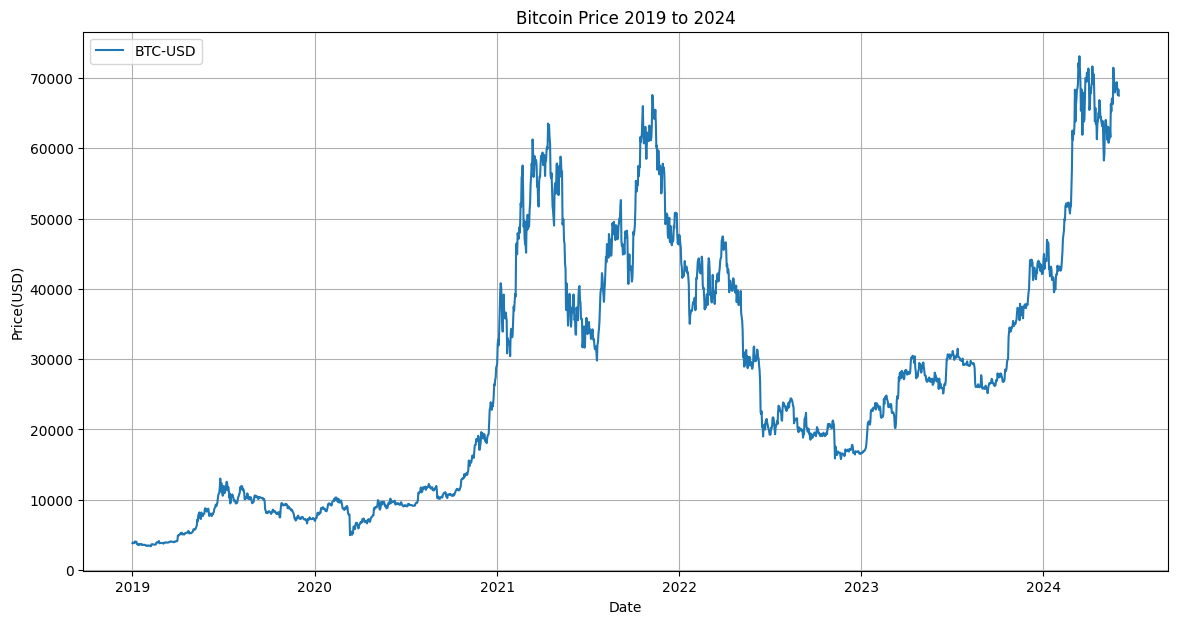

In [2]:
#fetch bitcoin price data from Yahoo fiance
bitcoin_data = yf.download('BTC-USD', start = '2019-01-01', end = '2024-06-01')

#plotting the Bitcoin price
plt.figure(figsize = (14, 7))
plt.plot(bitcoin_data.index, bitcoin_data['Close'], label='BTC-USD')
plt.title('Bitcoin Price 2019 to 2024')
plt.xlabel('Date')
plt.ylabel('Price(USD)')
plt.legend()
plt.grid(True)
plt.show()

**BitCoin Price Prediction**

[*********************100%%**********************]  1 of 1 completed
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz7jjzo49/b43xk3bl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz7jjzo49/za4mkd9r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47478', 'data', 'file=/tmp/tmpz7jjzo49/b43xk3bl.json', 'init=/tmp/tmpz7jjzo49/za4mkd9r.json', 'output', 'file=/tmp/tmpz7jjzo49/prophet_modelvzc0csg6/prophet_model-20240617193522.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:35:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:35:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Epoch 1/100
82/82 [==============================] - 3s 19ms/step - loss: 0.0305
Epoch 2/100
82/82 [==============================] - 2s 19ms/step - loss: 0.0026
Epoch 3/100
82/82 [==============================] - 1s 14ms/step - loss: 0.0022
Epoch 4/100
82/82 [==============================] - 1s 12ms/step - loss: 0.0018
Epoch 5/100
82/82 [==============================] - 1s 12ms/step - loss: 0.0017
Epoch 6/100
82/82 [==============================] - 1s 12ms/step - loss: 0.0014
Epoch 7/100
82/82 [==============================] - 1s 12ms/step - loss: 0.0013
Epoch 8/100
82/82 [==============================] - 1s 12ms/step - loss: 0.0012
Epoch 9/100
82/82 [==============================] - 1s 12ms/step - loss: 0.0011
Epoch 10/100
82/82 [==============================] - 1s 12ms/step - loss: 0.0010
Epoch 11/100
82/82 [==============================] - 1s 12ms/step - loss: 0.0010
Epoch 12/100
82/82 [==============================] - 1s 13ms/step - loss: 0.0013
Epoch 13/100
82/82 [=====

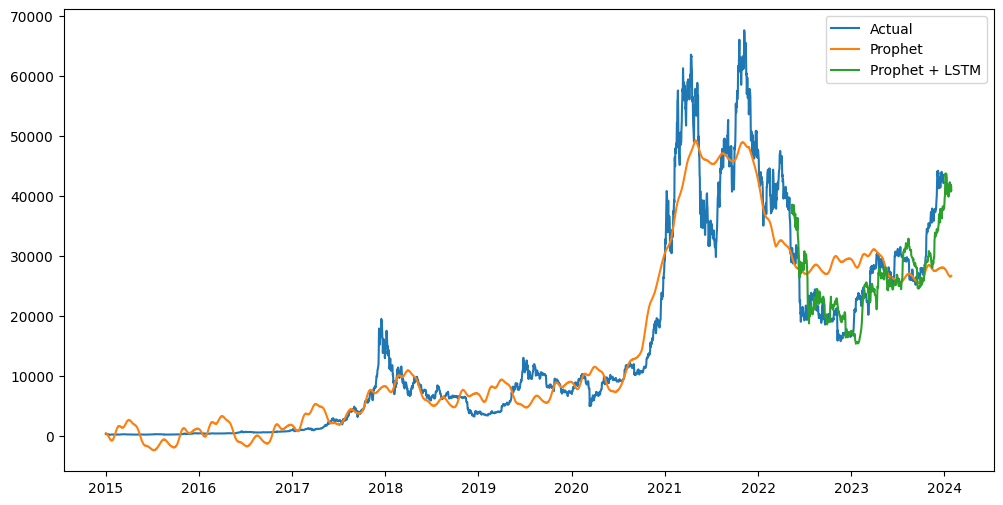

In [6]:
import pandas as pd
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

# 1. Data Collection
data = yf.download("BTC-USD", start="2015-01-01", end="2023-12-31")
df = data.reset_index()[['Date', 'Close']]
df.columns = ['ds', 'y']

# 2. Fit a Prophet model to the price data to capture the overall trend and seasonality.
m = Prophet()
m.fit(df)

# 3. Forecasting with Prophet: Generate predictions for the next 30 days.
future = m.make_future_dataframe(periods=30)  # Predict for next 30 days
forecast = m.predict(future)

# 4. Calculate Residuals: Compute the diff b/w actual prices vs Prophet's predictions (residuals).
    #These residuals represent the part of the price that Prophet couldn't explain.
residuals = (df['y'] - forecast['yhat'][:-30]).values.reshape(-1, 1)  # Reshape residuals

# 5. Prepare Data for LSTM: Rreprocess the residuals by scaling them and creating sequences for LSTM input.
scaler = MinMaxScaler(feature_range=(0, 1))
residuals_scaled = scaler.fit_transform(residuals)

# Split into training and test sets
train_size = int(len(residuals_scaled) * 0.80)
train_data, test_data = residuals_scaled[:train_size], residuals_scaled[train_size:]

# Create sequences for LSTM
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length - 1):
        xs.append(data[i:(i + seq_length), 0])
        ys.append(data[i + seq_length, 0])
    return np.array(xs), np.array(ys)

seq_length = 30  # Sequence length for LSTM input
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# 6. Build and Train LSTM Model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=100, batch_size=32)

# 7. Predict Residuals with LSTM
y_pred_scaled = model.predict(X_test)

# Invert scaling for LSTM predictions and residuals used in training
y_pred = scaler.inverse_transform(y_pred_scaled)
residuals = scaler.inverse_transform(residuals)

# Align Prophet predictions and actual values to the same length as LSTM predictions
prophet_forecast_test = forecast['yhat'][-len(y_pred):]

# 8. Combine Prophet and LSTM Predictions
final_prediction = prophet_forecast_test + y_pred.flatten()

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(df['ds'], df['y'], label='Actual')
plt.plot(forecast['ds'], forecast['yhat'], label='Prophet')
plt.plot(forecast['ds'][-len(y_pred):], final_prediction, label='Prophet + LSTM')
plt.legend()
plt.show()